In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv


## Data

Info about data

In [155]:
df_train = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv')
df_val = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv')
df_test = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv')

In [156]:
df_train

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


## EDA

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

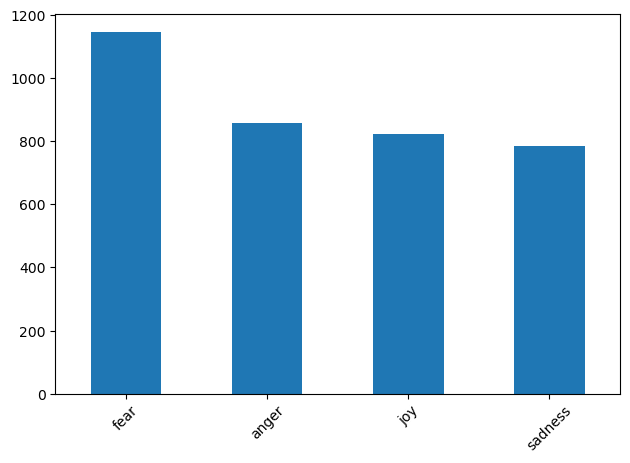

In [158]:
df_train['label'].value_counts().plot(kind = 'bar')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

## Data Cleaning

In [159]:
df_train['text']

0       Just got back from seeing @GaryDelaney in Burs...
1       Oh dear an evening of absolute hilarity I don'...
2       Been waiting all week for this game ❤️❤️❤️ #ch...
3       @gardiner_love : Thank you so much, Gloria! Yo...
4       I feel so blessed to work with the family that...
                              ...                        
3608    @VivienLloyd Thank you so much! Just home - st...
3609                Just put the winter duvet on ☃️❄️🌬☔️ 
3610    @SilkInSide @TommyJoeRatliff that's so pretty!...
3611    @BluesfestByron second artist announcement loo...
3612    I can literally eat creamy pesto pasta topped ...
Name: text, Length: 3613, dtype: object

### Removing Username Handles

In [160]:
import re

In [161]:
text = df_train['text'][0]
text

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

In [162]:
def remove_handle(text):
    string = re.sub(r"@\w+",' ', text)
    return string

In [163]:
remove_handle(text)

'Just got back from seeing   in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

### Removing \# Marks

In [164]:
text = df_train['text'][0]
text

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

In [165]:
def remove_hashtag(text):
    return re.sub(r' #',', ',text)

In [166]:
remove_hashtag(text)

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much, hilarious'

### Parsing Emojis to their meaning | ♥ -> Heart

In [167]:
import emoji

In [168]:
text = df_train['text'][2]

In [169]:
def parse_emoji(text):
    return emoji.demojize(text)

In [170]:
parse_emoji(text)

'Been waiting all week for this game :red_heart::red_heart::red_heart: #cheer #friday :red_heart:'

In [171]:
df_train['text'] = df_train['text'].apply(remove_handle)
df_train['text'] = df_train['text'].apply(remove_hashtag)
df_train['text'] = df_train['text'].apply(parse_emoji)

## Word2Vec

In [172]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

df_train['text'] = df_train['text'].apply(simple_preprocess)


In [173]:
df_train['text']

0       [just, got, back, from, seeing, in, burslem, a...
1       [oh, dear, an, evening, of, absolute, hilarity...
2       [been, waiting, all, week, for, this, game, re...
3       [thank, you, so, much, gloria, you, re, so, sw...
4       [feel, so, blessed, to, work, with, the, famil...
                              ...                        
3608    [thank, you, so, much, just, home, stunned, bu...
3609    [just, put, the, winter, duvet, on, snowman, s...
3610    [that, so, pretty, love, the, sky, in, the, ba...
3611    [second, artist, announcement, looking, good, ...
3612    [can, literally, eat, creamy, pesto, pasta, to...
Name: text, Length: 3613, dtype: object

In [174]:
import gensim

In [175]:
import gensim.downloader as api

In [176]:
gensim.downloader.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [214]:
model = api.load('word2vec-google-news-300')

In [178]:
vocab = model.key_to_index.keys()

In [179]:
X = df_train['text'].apply(lambda sent: model.get_mean_vector([word for word in sent if word in vocab]) )

In [180]:
y = df_train['label'].map({'fear':0, 'anger':1, 'joy':2, 'sadness':3}).values

In [181]:
X = np.vstack(X)

In [182]:
def create_features(df):
    df['text'] = df['text'].apply(remove_handle)
    df['text'] = df['text'].apply(remove_hashtag)
    df['text'] = df['text'].apply(parse_emoji)
    df['text'] = df['text'].apply(simple_preprocess)
    X = df['text'].apply(lambda sent: model.get_mean_vector([word for word in sent if word in vocab]))
    X = np.vstack(X)
    y = df['label'].map({'fear':0, 'anger':1, 'joy':2, 'sadness':3})   
    return X, y.values
    

In [183]:
X_val, y_val = create_features(df_val)

In [184]:
from sklearn import svm

clf = svm.SVC(kernel='poly')

clf.fit(X, y)

print(clf)

SVC(kernel='poly')


In [187]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_val)

report = classification_report(y_pred, y_val)

print(report)

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       147
           1       0.58      0.70      0.64        70
           2       0.76      0.76      0.76        79
           3       0.45      0.65      0.53        51

    accuracy                           0.68       347
   macro avg       0.66      0.69      0.66       347
weighted avg       0.72      0.68      0.69       347



In [189]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X, y)


y_pred_rf = rf.predict(X_val)


report_rf = classification_report(y_pred, y_val)


print(report_rf)


              precision    recall  f1-score   support

           0       0.85      0.64      0.73       147
           1       0.58      0.70      0.64        70
           2       0.76      0.76      0.76        79
           3       0.45      0.65      0.53        51

    accuracy                           0.68       347
   macro avg       0.66      0.69      0.66       347
weighted avg       0.72      0.68      0.69       347



In [196]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and fit the Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X, y)

# Predict the target variable for the training data
y_pred = gb.predict(X_val)

# Generate a classification report
report_gb = classification_report(y_pred, y_val)

# Print the classification report
print(report_gb)


              precision    recall  f1-score   support

           0       0.73      0.54      0.62       148
           1       0.52      0.60      0.56        73
           2       0.67      0.77      0.72        69
           3       0.45      0.58      0.50        57

    accuracy                           0.61       347
   macro avg       0.59      0.62      0.60       347
weighted avg       0.63      0.61      0.61       347



In [195]:
y_val.shape

(347,)

In [197]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'degree': [2, 3, 4]
}

# Create the SVM classifier
clf = svm.SVC(kernel='poly')

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'C': 1, 'degree': 4, 'gamma': 10}
Best Score:  0.7073945510204863


## Test Data

In [203]:
from sklearn import svm

# Create the SVM classifier with the specified parameters
clf = svm.SVC(kernel='poly', C=1, degree=4, gamma=10)

# Fit the classifier to the data
clf.fit(X, y)

# Print the trained classifier
print(clf)


SVC(C=1, degree=4, gamma=10, kernel='poly')


In [204]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_val)

report = classification_report(y_pred, y_val)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       120
           1       0.58      0.64      0.61        76
           2       0.82      0.79      0.81        82
           3       0.61      0.65      0.63        69

    accuracy                           0.69       347
   macro avg       0.69      0.69      0.69       347
weighted avg       0.70      0.69      0.70       347



In [211]:
def create_features_text(text):
    text = remove_handle(text)
    text = remove_hashtag(text)
    text = parse_emoji(text)
    text = simple_preprocess(text)
    print([word for word in text if word in vocab])
    X = model.get_mean_vector([word for word in text if word in vocab])
    X = np.vstack(X)
    return X

In [215]:
model.get_mean_vector(['why'])

array([ 6.70078397e-02,  5.51193533e-03,  9.64048281e-02,  1.34556070e-02,
       -4.02047038e-02,  1.71842687e-02,  5.40385805e-02, -2.98292972e-02,
        8.73263478e-02,  2.83162165e-02, -9.56482906e-03, -8.34355727e-02,
        2.89646797e-02, -2.78839078e-02, -1.12400249e-01,  1.59089580e-01,
        2.86404486e-03, -7.52217025e-02, -6.44139871e-02, -2.16154326e-02,
        2.87485253e-02,  1.81029248e-03,  1.64277293e-02,  2.26962045e-02,
       -9.85663757e-02,  3.97723950e-02,  3.84754688e-02,  3.22069936e-02,
        3.48008461e-02,  1.66438837e-02,  8.37597996e-03,  1.14129484e-01,
       -1.14561794e-02, -2.68031359e-02,  2.85323709e-02,  2.39931308e-02,
        3.67462374e-02, -1.25909895e-02,  3.32877673e-02,  3.63139287e-02,
        1.15858719e-01,  1.29152210e-02,  4.69054878e-02, -9.89986807e-02,
       -4.75539528e-02,  9.40271281e-03, -2.09399499e-03, -5.96585944e-02,
       -6.74401522e-02,  6.35493696e-02, -5.46870455e-02, -3.56654637e-02,
        2.28042807e-02, -

In [269]:
X_input = create_features_text("I ♥ this song most")

['this', 'song', 'most']


In [270]:
X_input = X_input.reshape(-1,300)

In [271]:
clf.predict(X_input).item()

2